In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold

In [2]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "SanDiego"
year = 2014

import os


def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [3]:
n_splits = 2
import sys
case=2
a=2
cost='abs'

In [4]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [5]:
df, dfc = create_matrix_single_region("SanDiego", year)
tensor = get_tensor(df, dfc)

In [25]:
from common import compute_rmse
pred = {}
sd = {}
out = {}
for n_splits in range(2, len(df)):
    print n_splits
    pred[n_splits] = {}
    sd[n_splits] = {}
    out[n_splits] = {}
    kf = KFold(n_splits=n_splits)
    for test, train in kf.split(df):
        assert(len(test)+1>=len(train))
        
        train_ix = df.index[train]
        
        test_ix = df.index[test]

        tensor_copy = tensor.copy()
        tensor_copy[test, 1:, :] = np.NaN
        H, A, T = learn_HAT(case, tensor_copy, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost)
        HAT = multiply_case(H, A, T, case)
        for appliance in APPLIANCES_ORDER:
            if appliance not in pred[n_splits]:
                pred[n_splits][appliance] = []

            pred[n_splits][appliance].append(pd.DataFrame(HAT[test, appliance_index[appliance], :], index=test_ix))
    for appliance in APPLIANCES_ORDER:
        temp = pd.concat(pred[n_splits][appliance])
        assert(len(temp)==len(df)*(n_splits-1))
        pred[n_splits][appliance] = temp.groupby(temp.index).mean().ix[df.index]
        sd[n_splits][appliance] = temp.groupby(temp.index).mean().ix[df.index]
    
   
    for appliance in APPLIANCES_ORDER[1:]:
        
        if appliance=="hvac":
            out[n_splits][appliance] = compute_rmse(appliance, pred[n_splits][appliance][range(4, 10)],'SanDiego')[2]
        else:   
            out[n_splits][appliance] = compute_rmse(appliance, pred[n_splits][appliance],'SanDiego')[2]


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


In [26]:
from plot_functions import *

In [27]:
c.columns[::-1]

Float64Index([         50.0, 33.3333333333,          25.0,          20.0,
              16.6666666667, 14.2857142857,          12.5, 11.1111111111,
                       10.0, 9.09090909091, 8.33333333333, 7.69230769231,
              7.14285714286],
             dtype='float64')

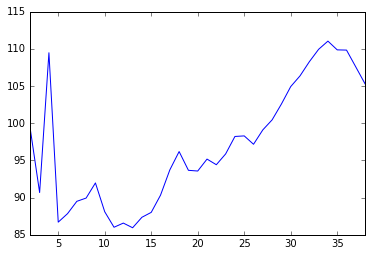

In [39]:
pd.DataFrame(out).ix['hvac'][:].plot()

In [28]:
c = pd.DataFrame(out)
c.columns = [100.0/x for x in c.columns]
c = c[c.columns[::-1]]

0 hvac
1 fridge
2 mw
3 dw
4 wm
5 oven


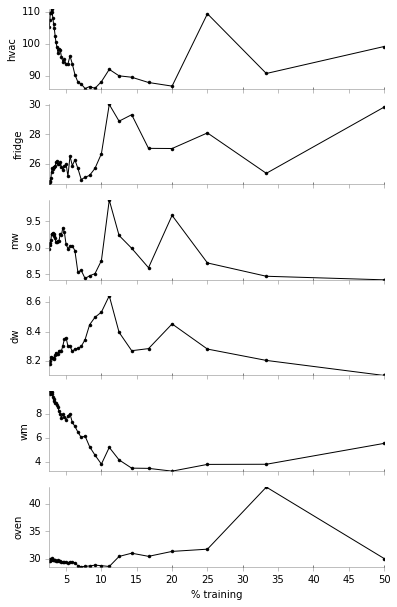

In [48]:
fig, ax = plt.subplots(nrows=6, figsize=(6, 10), sharex=True)
for i, appliance in enumerate(APPLIANCES_ORDER[1:]):
    print i, appliance
    c.T[appliance].plot(ax=ax[i], color='k', marker='.',  logx=False)
    format_axes(ax[i])
    ax[i].set_ylabel(appliance)
    ax[i].locator_params(tight=True, nbins=4, axis='y')
ax[-1].set_xlabel("% training");
ax[-1].locator_params(tight=True, nbins=10, axis='x')

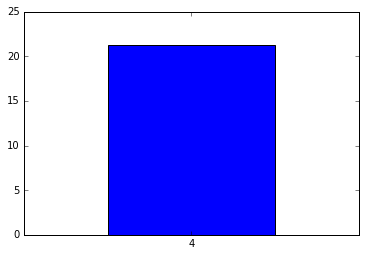

In [135]:
pd.DataFrame(out).ix['hvac'].plot(kind='bar',rot=0)


In [164]:
from common import compute_rmse_fraction, compute_rmse

In [35]:
appliance='hvac'
gtf, pf, rms, f = compute_rmse(appliance, pred[n_splits][appliance][range(4, 10)],'SanDiego')
f[f>np.percentile(f, 90)].sort_values()[::-1].head(10)

hvac_9  9370    274.205720
        527     271.623605
        4095    269.434995
hvac_8  9370    259.533940
hvac_5  9370    254.124171
hvac_7  9370    252.170256
hvac_8  527     221.765679
hvac_9  2606    201.378624
hvac_6  9370    200.634527
hvac_9  3864    193.560698
dtype: float64

In [36]:
def analysis(appliance, home, month):
    analysis_ser = pd.Series([gtf.ix['%s_%d' %(appliance, month),home],
                             pf.ix['%s_%d' %(appliance, month),home],
                             df.loc[home,'%s_%d' %("aggregate",month)]])
    analysis_ser.index = ['Appliance GT % of agg','Appliance Pred % of agg', 'GT (aggregate) [kWh]']
    return analysis_ser

In [42]:
analysis('hvac', 527, 8)

Appliance GT % of agg       577.740662
Appliance Pred % of agg     355.974983
GT (aggregate) [kWh]       1157.161133
dtype: float64

In [38]:
from plot_functions import *
def plot_appliances_aggregate(home, appliances=['hvac']):
    temp = {} 
    temp['aggregate'] = df.ix[home][['aggregate_%d' %month for month in range(1, 13)]].values
    for appliance in appliances:
        temp[appliance] = df.ix[home][['%s_%d' %(appliance, month) for month in range(1, 13)]].values
    temp_df = pd.DataFrame(temp, index=range(1, 13))
    temp_df.plot(color=tableau20blind[::2])
    format_axes(plt.gca())
    plt.xlabel("Month of year")
    plt.ylabel("Energy (kWh)")

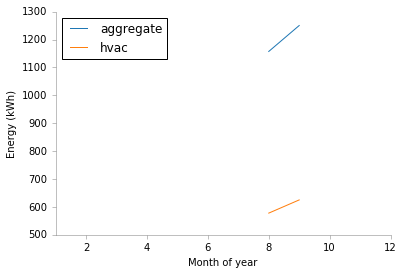

In [41]:
plot_appliances_aggregate(527)

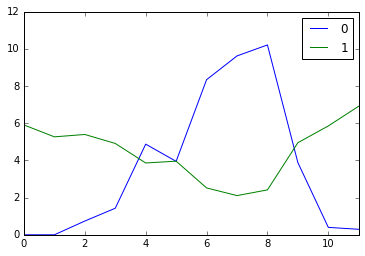

In [41]:
pd.DataFrame(T).plot()

In [25]:
pd.Series(out)

dw         2.075424
fridge     6.500384
hvac      12.359623
mw         2.591136
oven       4.402889
wm         0.805351
dtype: float64

In [26]:
pred['hvac'].describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000,39.000000
mean,2.019141,1.800407,17.930834,32.841665,107.586378,87.663020,182.581516,209.742593,222.891978,86.183734,10.734851,8.919451
std,1.121065,0.999637,12.113276,23.186966,78.513445,63.803845,134.098560,154.207951,163.837490,62.475208,6.734655,5.240128
min,0.062482,0.055709,3.166105,4.562446,11.904767,9.901167,19.199608,21.862864,23.278437,9.998936,2.556355,2.570146
25%,1.260505,1.123937,8.344732,14.805471,47.420278,38.712415,80.114130,91.962465,97.745665,38.156645,5.260004,4.742898
50%,1.746536,1.557314,14.156520,25.260501,78.291192,64.083829,131.380249,150.686120,160.159342,63.344459,8.535422,7.379092
75%,2.888973,2.576136,27.351551,50.922795,168.695750,137.290758,286.965045,329.730940,350.398747,134.907401,15.690095,12.680111
max,4.997533,4.456103,45.831418,87.898899,297.650769,241.926640,508.311773,584.479200,621.026903,236.981742,25.419999,20.328867
